In [260]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### 1. Load dataset

In [261]:
data = pd.read_csv("online_retail_II.csv", 
                   on_bad_lines='skip',
                   encoding= 'unicode_escape',
                   parse_dates = ['InvoiceDate'], 
                   infer_datetime_format = True)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [262]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


### 2. Data processing

In [263]:
data = data.dropna().drop_duplicates().reset_index(drop=True)
data.shape

(797885, 8)

In [264]:
data[data.Quantity <= 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
797439,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
797523,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
797690,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
797691,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [265]:
data = data[data.Quantity > 0].reset_index(drop=True)
data.shape

(779495, 8)

In [266]:
data.Country.value_counts(1) * 100

Country
United Kingdom          89.857408
Germany                  2.109058
EIRE                     1.997062
France                   1.733430
Netherlands              0.652987
Spain                    0.469920
Belgium                  0.392049
Switzerland              0.385634
Portugal                 0.302247
Australia                0.229892
Channel Islands          0.198975
Italy                    0.184992
Sweden                   0.168956
Norway                   0.165492
Cyprus                   0.145735
Finland                  0.132393
Austria                  0.118282
Denmark                  0.099808
Greece                   0.084285
Unspecified              0.066453
Poland                   0.064657
Japan                    0.060039
USA                      0.052470
United Arab Emirates     0.049134
Singapore                0.043490
Israel                   0.040924
Malta                    0.036177
Canada                   0.029250
Iceland                  0.028480
Lithua

In [267]:
data = data[data.Country == 'United Kingdom'].reset_index(drop=True)
data.shape

(700434, 8)

In [268]:
data['total_price'] = data['Quantity'] * data['Price']
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


### 3. RFM 

In [269]:
last_day = data.InvoiceDate.max()
last_day

Timestamp('2011-12-09 12:49:00')

In [270]:
rfm_df = data.groupby('Customer ID').agg(
    {
        "InvoiceDate" : lambda x: (last_day - x.max()).days, 
        "Invoice" : lambda x: x.nunique(),
        "total_price" : lambda x: x.sum()
    }
)

rfm_df.columns = ['recency', 'frequency', 'monetary']
rfm = rfm_df.reset_index()
rfm

,Customer ID,recency,frequency,monetary
0,12346.0,325,12,77556.46
1,12608.0,404,1,415.79
2,12745.0,486,2,723.85
3,12746.0,540,1,254.55
4,12747.0,1,26,8898.48
...,...,...,...,...
5348,18283.0,3,22,2664.90
5349,18284.0,431,1,461.68
5350,18285.0,660,1,427.00
5351,18286.0,476,2,1296.43


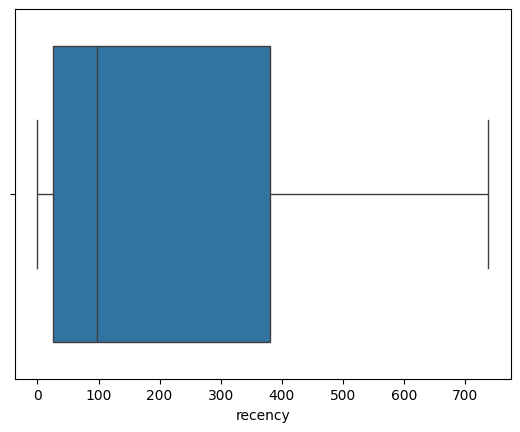

In [271]:
sns.boxplot(data = rfm, 
            x = 'recency')
plt.show()

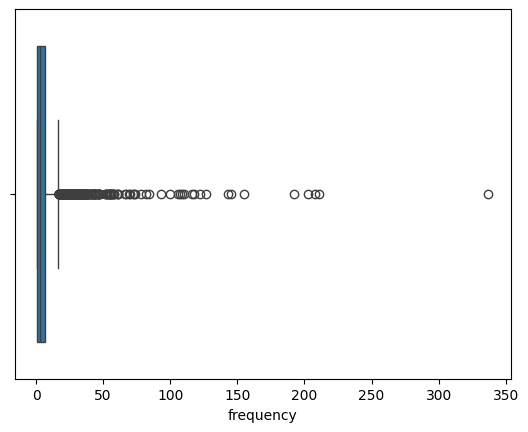

In [272]:
sns.boxplot(data = rfm, 
            x = 'frequency')
plt.show()

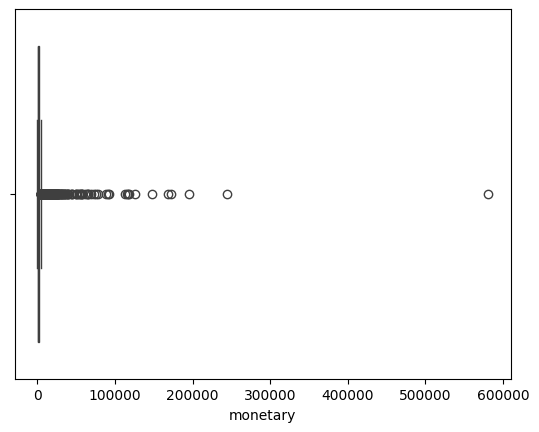

In [273]:
sns.boxplot(data = rfm, 
            x = 'monetary')
plt.show()

In [274]:
def remove_outlier(data, col, q1 = 0.05, q3 = 0.95): 
    lower = data[col].quantile(q1)
    upper = data[col].quantile(q3)
    
    data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

In [275]:
for col in rfm.columns[1:]: 
    rfm = remove_outlier(rfm, col)
    
rfm = rfm.reset_index(drop=True)
rfm

,Customer ID,recency,frequency,monetary
0,12608.0,404,1,415.79
1,12745.0,486,2,723.85
2,12746.0,540,1,254.55
3,12777.0,457,1,519.45
4,12819.0,457,1,540.52
...,...,...,...,...
4146,18281.0,180,2,201.14
4147,18282.0,7,2,178.05
4148,18284.0,431,1,461.68
4149,18286.0,476,2,1296.43


### 4. AHP

#### 4.1. Scratch

In [276]:
''' priority score: F > R > M
    matrix 3x3
            R   F   M 
        R   1   1/2 2
        F   2   1   3
        M   1/2 1/3 1
'''

priority_matrix = np.array(
                        [[1,1/2,2],
                        [2,1,3],
                        [1/2,1/3,1]]
                    )

priority_matrix

array([[1.        , 0.5       , 2.        ],
       [2.        , 1.        , 3.        ],
       [0.5       , 0.33333333, 1.        ]])

In [277]:
col_sum = np.sum(priority_matrix, axis=0)
col_sum

array([3.5       , 1.83333333, 6.        ])

In [278]:
priority_matrix = priority_matrix/col_sum[np.newaxis, :]
priority_matrix

array([[0.28571429, 0.27272727, 0.33333333],
       [0.57142857, 0.54545455, 0.5       ],
       [0.14285714, 0.18181818, 0.16666667]])

In [279]:
weight = np.average(priority_matrix, axis=1)
weight

array([0.2972583 , 0.53896104, 0.16378066])

In [280]:
theta_max = np.dot(weight, col_sum)
theta_max

3.011183261183261

In [281]:
n = 3 
CI = (theta_max-n)/(n-1)
CI

0.005591630591630592

In [282]:
RI = 0.58 # random index

CR = CI/RI
CR

0.00964074239936309

CR < 10% => accept

#### 4.2. Library

In [283]:
!pip install ahpy

In [284]:
import ahpy

components_comparisons = {('R', 'F'): 1/2, ('R', 'M'): 2, ('F', 'M'): 3}

weight_rfm = ahpy.Compare(name='rfm', comparisons=components_comparisons, precision=3, random_index='saaty')
weight_rfm.target_weights

{'F': 0.54, 'R': 0.297, 'M': 0.163}

In [285]:
weight_rfm.consistency_ratio

0.009

### 5. CLV

In [286]:
rfm

,Customer ID,recency,frequency,monetary
0,12608.0,404,1,415.79
1,12745.0,486,2,723.85
2,12746.0,540,1,254.55
3,12777.0,457,1,519.45
4,12819.0,457,1,540.52
...,...,...,...,...
4146,18281.0,180,2,201.14
4147,18282.0,7,2,178.05
4148,18284.0,431,1,461.68
4149,18286.0,476,2,1296.43


In [287]:
from sklearn.preprocessing import MinMaxScaler

for col in rfm.columns[1:]: 
    scaler = MinMaxScaler()
    rfm[col] = scaler.fit_transform(rfm[col].values.reshape(-1, 1))
    if col == 'recency': 
        rfm['recency'] = 1 - rfm['recency']
rfm

,Customer ID,recency,frequency,monetary
0,12608.0,0.355305,0.000000,0.059370
1,12745.0,0.223473,0.058824,0.119510
2,12746.0,0.136656,0.000000,0.027892
3,12777.0,0.270096,0.000000,0.079607
4,12819.0,0.270096,0.000000,0.083720
...,...,...,...,...
4146,18281.0,0.715434,0.058824,0.017465
4147,18282.0,0.993569,0.058824,0.012957
4148,18284.0,0.311897,0.000000,0.068328
4149,18286.0,0.239550,0.058824,0.231292


In [288]:
!pip install scikit-fuzzy 

In [289]:
import skfuzzy as fuzz

X = rfm.values[:, 1:]

pcis = []
for c in range(2, 11):
    cntr, u, u0, d, jm, p, pci = fuzz.cluster.cmeans(X.T, c, 2, error=0.005, maxiter=1000)
    pcis.append(pci)

Text(0, 0.5, 'Fuzzy partition coefficient')

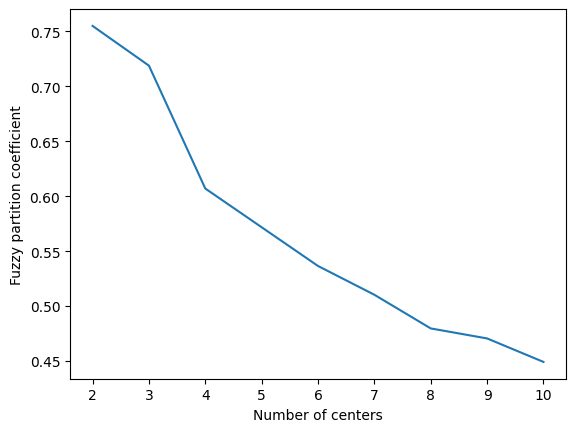

In [290]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], pcis)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

#### Test with 2 clusters

In [291]:
cntr, u, u0, d, jm, p, pci = fuzz.cluster.cmeans(X.T, 2, 2, error=0.005, maxiter=1000)

In [292]:
cluster_membership = np.argmax(u, axis=0)
center = cntr.T
center

array([[0.38507403, 0.90125954],
       [0.08186673, 0.23642217],
       [0.1108548 , 0.26715684]])

In [293]:
unique_values, counts = np.unique(cluster_membership, return_counts=True)
unique_values, counts

(array([0, 1]), array([1602, 2549]))

In [294]:
result = pd.DataFrame({
    'cluster' : unique_values,
    'num_of_cus' : counts,
    'R' : center[0, :],
    'F' : center[1, :],
    'M' : center[2, :]
})

result['clv_value'] = 0.297*result['R'] + 0.54*result['F'] + 0.163*result['M']
result['clv_ranking'] = result['clv_value'].rank(ascending=False)
result.head()

,cluster,num_of_cus,R,F,M,clv_value,clv_ranking
0,0,1602,0.385074,0.081867,0.110855,0.176644,2.0
1,1,2549,0.901260,0.236422,0.267157,0.438889,1.0


#### Test with 3 clusters

In [295]:
cntr, u, u0, d, jm, p, pci = fuzz.cluster.cmeans(X.T, 3, 2, error=0.005, maxiter=1000)

In [296]:
cluster_membership = np.argmax(u, axis=0)
center = cntr.T
center

array([[0.90568358, 0.88472945, 0.31933808],
       [0.48182901, 0.11333325, 0.06347632],
       [0.55560294, 0.12886441, 0.09058256]])

In [297]:
unique_values, counts = np.unique(cluster_membership, return_counts=True)
unique_values, counts

(array([0, 1, 2]), array([ 835, 1923, 1393]))

In [298]:
result = pd.DataFrame({
    'cluster' : unique_values,
    'num_of_cus' : counts,
    'R' : center[0, :],
    'F' : center[1, :],
    'M' : center[2, :]
})

result['clv_value'] = 0.297*result['R'] + 0.54*result['F'] + 0.163*result['M']
result['clv_ranking'] = result['clv_value'].rank(ascending=False)
result.head()

,cluster,num_of_cus,R,F,M,clv_value,clv_ranking
0,0,835,0.905684,0.481829,0.555603,0.619739,1.0
1,1,1923,0.884729,0.113333,0.128864,0.344970,2.0
2,2,1393,0.319338,0.063476,0.090583,0.143886,3.0
